In [1]:
import pandas as pd 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split , cross_val_score
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,ConfusionMatrixDisplay , accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt


In [9]:
df = pd.read_csv('..\\data\\processed\\train_optimized.csv')
df_test = pd.read_csv('..\\data\\processed\\test_cleaned.csv')

X = df.drop(['id', 'target'], axis=1)
y = df['target'] 

X_test = df_test[['text_cleaned', 'keyword']]
y_test = df_test['target']

# Fill NaN values in 'keyword' column with empty string
X_test['keyword'] = X_test['keyword'].fillna('')
df_test['target'].value_counts()



C:\Users\ilyes\AppData\Local\Temp\ipykernel_13380\4155077942.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['keyword'] = X_test['keyword'].fillna('')


target
0    430
1    319
Name: count, dtype: int64

In [3]:
preprocessor = ColumnTransformer(transformers=[
    ('text_cleaned', TfidfVectorizer(), 'text_cleaned'),
    ('keyword', TfidfVectorizer(), 'keyword')
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC(probability=True))
])

param_grid = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__class_weight': [None, 'balanced']
}

In [4]:
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear'],
    'svm__class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid.fit(X, y)
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur F1-score :", grid.best_score_)

# Recuperation du meilleur modele
best_svm = grid.best_estimator_
best_params = grid.best_params_
best_cv_score = grid.best_score_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleurs paramètres : {'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear'}
Meilleur F1-score : 0.7279646815862899


Accuracy sur le jeu de test : 0.7971
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       430
           1       0.75      0.78      0.77       319

    accuracy                           0.80       749
   macro avg       0.79      0.79      0.79       749
weighted avg       0.80      0.80      0.80       749

Confusion Matrix:
[[349  81]
 [ 71 248]]


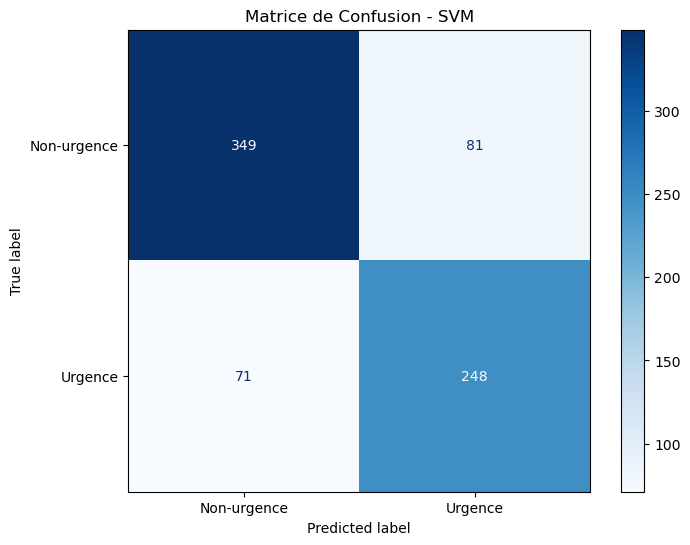

In [5]:


model = best_svm

y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

accuracy = (y_pred == y_test).mean()
print(f"Accuracy sur le jeu de test : {accuracy:.4f}")
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
#affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-urgence', 'Urgence']).plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matrice de Confusion - SVM')
plt.savefig('../results/svm/confusion_matrix.png', dpi=300, bbox_inches='tight')
# 📊 Évaluation Détaillée du Modèle Optimisé


In [6]:
# 📊 Évaluation Détaillée du Modèle Optimisé
print("📊 Évaluation complète du meilleur modèle SVM...")

# Prédictions avec le modèle optimisé
y_pred_train_opt = best_svm.predict(X)

# 📈 Métriques complètes
def calculate_metrics(y_true, y_pred, set_name):
    """Calcule toutes les métriques importantes"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n📋 Métriques {set_name}:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    return {
        'Set': set_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    }

# Calcul des métriques
train_metrics = calculate_metrics(y, y_pred_train_opt, "Train")



📊 Évaluation complète du meilleur modèle SVM...

📋 Métriques Train:
   Accuracy:  0.9287
   Precision: 0.9181
   Recall:    0.9061
   F1-Score:  0.9120


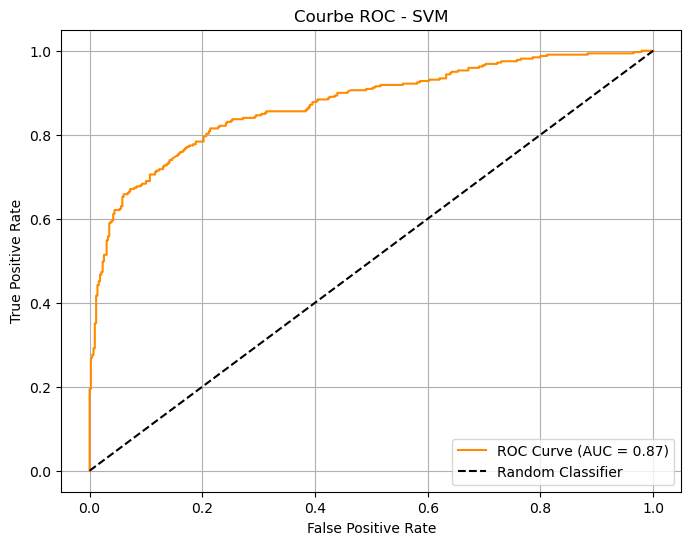

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - SVM")
plt.legend(loc="lower right")
plt.grid()
plt.show()